### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
env = CabDriver()
states_track=collections.defaultdict(dict)
def initialise_tracking_states():
    track_state_action_pair = [(tuple(env.state_encod_arch1([5,5,5])),[i for i,a in enumerate(env.action_space) if a ==(3,4)][0]),
                            (tuple(env.state_encod_arch1([2,10,6])),[i for i,a in enumerate(env.action_space) if a ==(2,1)][0]),
                            (tuple(env.state_encod_arch1([3,23,6])),[i for i,a in enumerate(env.action_space) if a ==(3,2)][0]),
                            (tuple(env.state_encod_arch1([3,23,5])),[i for i,a in enumerate(env.action_space) if a ==(3,2)][0])]
    for s,a in track_state_action_pair:
        states_track[s][a]=[]

In [4]:
initialise_tracking_states()

In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size,states_track):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor =0.95
        self.learning_rate =0.001        
        self.epsilon_max = 1
        self.epsilon_decay = -0.0008
        self.epsilon_min = 0.01
        self.epsilon = 1
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        
        self.loss=[]
        self.states_track=states_track


    # approximate Q function using Neural Network
    def build_model(self):
        
        input_shape = self.state_size
        model = Sequential()   
        
        model.add(Dense(64, input_dim=self.state_size, activation='relu',kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))


        model.add(Dense(self.action_size, activation='linear',kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, possible_actions_index, actions,episode):

        if np.random.rand() <= self.epsilon:
            random_action=random.choice(list(enumerate(possible_actions_index)))
            action_index=random_action[1]
            action=actions[random_action[0]]
        
        else:

            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            max_action_index=np.argmax(q_value[0,possible_actions_index])
            action_index=possible_actions_index[max_action_index]
            action=actions[max_action_index]

        
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(self.epsilon_decay*episode)
            
        return action_index,action   


    def append_sample(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self,episode,episode_time):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards = [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                
            target = self.model.predict(update_input)
            
            target_qval = self.model.predict(update_output)
            
            
            for i in range(self.batch_size):
                if episode_time < 30*24 :
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                    
                    
            history=self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
            if ((episode+1) % 100) == 0:
                self.loss.append(history.history['loss'])

        
    def update_state_track(self):
        for s in states_track:
            for a in states_track[s]:
                self.states_track[s][a].append(self.model.predict(np.array(s).reshape(1, self.state_size))[0][a])
                
        
    def save(self, name):
        self.model.save(name)

In [7]:
Episodes = 10000

### DQN block

In [8]:
state_size = env.state_size 
action_size = len(env.action_space) +1 
agent = DQNAgent(state_size, action_size,states_track)

In [9]:
import time
start_time=time.time()
track_rewards=[]
for episode in range(Episodes):

    curr_state = env.reset()
    #print("start->",curr_state)
    episode_time=0
    total_reward=0

    
    while episode_time < 30*24:
    

        possible_actions_index,actions=env.requests(curr_state)
        #print(possible_actions_index,actions)
    
        action_index,action = agent.get_action(env.state_encod_arch1(curr_state), possible_actions_index, actions,episode)
        #print("action & index->", action,action_index)
    
        next_state = env.next_state_func(curr_state, action, Time_matrix)
        reward , time_step = env. reward_func(curr_state, action, Time_matrix)
        #print(next_state,reward, time_step)
        
        agent.append_sample(env.state_encod_arch1(curr_state), action_index, reward, env.state_encod_arch1(next_state))
    

        episode_time += time_step        
        total_reward += reward
        
        agent.train_model(episode,episode_time)
        
        curr_state=next_state
        
        #print("time elpased->",episode_time)
        
    
    track_rewards.append(total_reward)
    
    agent.update_state_track()
           
        
    if ((episode+1) % 500) == 0:   
        print("episode:", episode+1, "  total_reward:", total_reward, "  memory length:",len(agent.memory), "  epsilon:", agent.epsilon)
    
    if ((episode+1) % 1000) == 0:
        print('Processed %dk episodes'%((episode+1)/1000))

        
    if (episode+1) % 1000 == 0:
        agent.save(name="model_weights.h5")

#agent.save(name="model_weights.h5")
save_obj(states_track,'States_tracked')
save_obj(track_rewards,'Rewards_tracked') 

episode: 500   total_reward: 495.0   memory length: 2000   epsilon: 0.6741479514657738
episode: 1000   total_reward: 996.0   memory length: 2000   epsilon: 0.45519168540101296
Processed 1k episodes
episode: 1500   total_reward: 1336.0   memory length: 2000   epsilon: 0.30842091105269087
episode: 2000   total_reward: 1566.0   memory length: 2000   epsilon: 0.21003751883483712
Processed 2k episodes
episode: 2500   total_reward: 1550.0   memory length: 2000   epsilon: 0.14408915883422307
episode: 3000   total_reward: 1919.0   memory length: 2000   epsilon: 0.09988265112263657
Processed 3k episodes
episode: 3500   total_reward: 1681.0   memory length: 2000   epsilon: 0.07025014283833103
episode: 4000   total_reward: 1662.0   memory length: 2000   epsilon: 0.050386878521043905
Processed 4k episodes
episode: 4500   total_reward: 1980.0   memory length: 2000   epsilon: 0.03707213426946193
episode: 5000   total_reward: 2102.0   memory length: 2000   epsilon: 0.02814699428978873
Processed 5k ep

### Tracking Convergence

In [10]:
with open('States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle) 

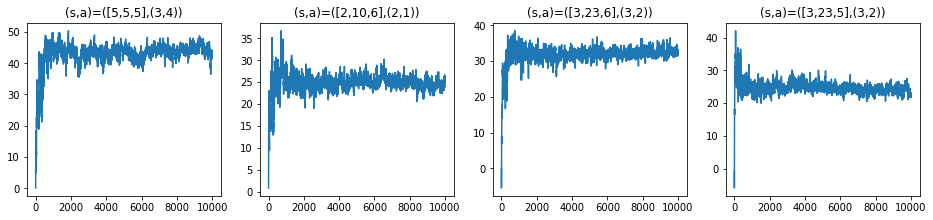

In [11]:
plt.figure(0, figsize=(16,7))
plt.subplot(241)
t1=States_track[tuple(env.state_encod_arch1([5,5,5]))][10]
plt.title("(s,a)=([5,5,5],(3,4))")
plt.plot(np.asarray(range(0, len(t1))),np.asarray(t1))


plt.subplot(242)
t2=States_track[tuple(env.state_encod_arch1([2,10,6]))][4]
plt.title("(s,a)=([2,10,6],(2,1))")
plt.plot(np.asarray(range(0, len(t2))),np.asarray(t2))

plt.subplot(243)
t3=States_track[tuple(env.state_encod_arch1([3,23,6]))][9]
plt.title("(s,a)=([3,23,6],(3,2))")
plt.plot(np.asarray(range(0, len(t3))),np.asarray(t3))

plt.subplot(244)
t4=States_track[tuple(env.state_encod_arch1([3,23,5]))][9]
plt.title("(s,a)=([3,23,5],(3,2))")
plt.plot(np.asarray(range(0, len(t4))),np.asarray(t4))


plt.show()

In [12]:
with open('Rewards_tracked.pkl', 'rb') as handle1:
    rewards_track = pickle.load(handle1) 

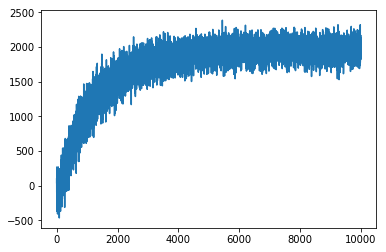

In [13]:
plt.plot(list(range(len(rewards_track))), rewards_track)
plt.show()

### Testing

In [15]:
from keras.models import load_model
model1 = load_model('model_weights.h5')

In [16]:
model1.predict(env.state_encod_arch1([2,10,6]).reshape(1, env.state_size))

array([[-19.478249 ,  -1.3834771,  -7.7402277, -23.221546 ,  25.170635 ,
         16.805635 ,  16.024017 ,  25.10121  , -15.3411455,  -2.6324553,
          4.319205 , -40.08593  , -31.761515 , -16.759699 ,   2.06785  ,
         -6.017052 , -16.461859 , -22.603428 , -38.06514  , -22.151768 ,
         -4.706699 ]], dtype=float32)